In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from plotting_utils import figSize


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

files = glob.glob('D:/T5_ClosedLoop/*')

## Factor analysis hyperparameter sweep

In [2]:
dat      = DataStruct(files[2])
window   = 5


In [147]:
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from lineplots import plotsd
from stabilizer_utils import *

model_type         = 'PCA'
n_components       = 3
data               = np.dstack([dat.TX[i][:20, :] for i in np.where(dat.trialType == 'cursor')[0] ])
unique, conditions = np.unique(np.vstack([dat.targetPos[i][0, :] for i in np.where(dat.trialType == 'cursor')[0] ]), return_inverse = True, axis = 0)

model, ll     = fit_ConditionAveragedModel(model_type, {'n_components' : n_components}, data, conditions)

Text(0.5, 0.92, 'First 400 msec trial activity (55.6%)')

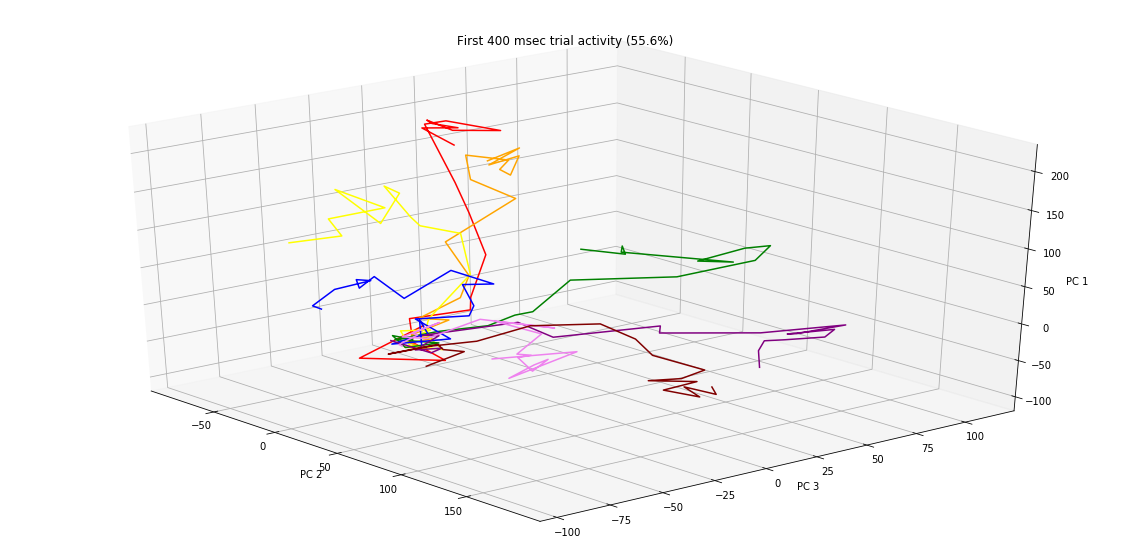

In [148]:
from mpl_toolkits.mplot3d import Axes3D 

figSize(10, 20)

endtrl_data       = np.dstack([dat.TX[i][:20, :] for i in np.where(dat.trialType == 'cursor')[0] ])
avgd_data, _      = get_ConditionAveraged(endtrl_data, conditions)
colors            = ['r', 'orange', 'yellow',  'green', 'k', 'blue', 'purple', 'violet', 'maroon']

fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

for i, color in zip(np.arange(avgd_data.shape[2]), colors):
    if (unique[i] != [0, 0]).any():
        latent = model.transform(avgd_data[:, :, i])
        ax.plot(latent[:, 1], latent[:, 2], latent[:, 0], color = color)
        
angle = 320
ax.view_init(30, angle)
ax.set_xlabel('PC 2')
ax.set_ylabel('PC 3')
ax.set_zlabel('PC 1')
var_explained = np.round(100 * sum(model.explained_variance_ratio_), 1)
ax.set_title('First 400 msec trial activity (' + str(var_explained) + '%)')


In [139]:
model_type         = 'PCA'
n_components       = np.arange(2, 21)
data               = np.dstack([dat.TX[i][:20, :] for i in np.where(dat.trialType == 'cursor')[0] ])
unique, conditions = np.unique(np.vstack([dat.targetPos[i][0, :] for i in np.where(dat.trialType == 'cursor')[0] ]), return_inverse = True, axis = 0)

_, models          = latentSweep(model_type, data, conditions, n_components)

Text(0, 0.5, 'Variance explained')

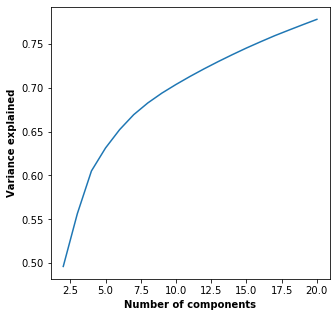

In [142]:
figSize(5,5)
plt.plot(n_components, [sum(models[i].explained_variance_ratio_) for i in range(len(models))])
plt.xlabel('Number of components', fontweight = 'bold')
plt.ylabel('Variance explained', fontweight = 'bold')

### train linear regression on day 0, get baseline performance measure

- use latent space and full activity to estimate cursorErr signal

TODO:
- set up proper latent space decoder cross-validation (do condition averaged PCA on each fold)

In [226]:
model_type         = 'PCA'
n_components       = 12
data               = np.dstack([dat.TX[i][:20, :] for i in np.where(dat.trialType == 'cursor')[0] ])
unique, conditions = np.unique(np.vstack([dat.targetPos[i][0, :] for i in np.where(dat.trialType == 'cursor')[0] ]), return_inverse = True, axis = 0)
model, ll          = fit_ConditionAveragedModel(model_type, {'n_components' : n_components}, data, conditions)

features_observed = np.vstack([dat.TX[i] for i in np.where(dat.trialType == 'cursor')[0] ])
features_latent   = model.transform(features_observed)
targets           = np.vstack([dat.targetPos[i] - dat.cursorPos[i] for i in np.where(dat.trialType == 'cursor')[0] ])

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

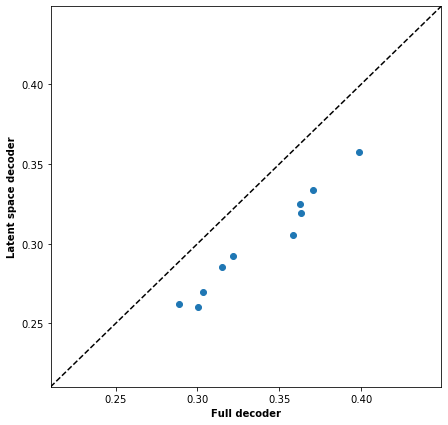

In [229]:
latent_decoder = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])
full_decoder   = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])

scores_latent   = cross_val_score(decoder, features_latent, targets, cv = 10)
scores_observed = cross_val_score(decoder, features_observed, targets, cv = 10)

figSize(7, 7)
plt.scatter(scores_observed, scores_latent)
plt.ylabel('Latent space decoder', fontweight = 'bold')
plt.xlabel('Full decoder', fontweight = 'bold')

minval = np.min([np.min(scores_observed), np.min(scores_latent)]) - 0.05
maxval = np.max([np.max(scores_observed), np.max(scores_latent)]) + 0.05
plt.xlim([minval, maxval])
plt.ylim([minval, maxval])
plt.plot([minval, maxval], [minval, maxval], color = 'k', linestyle = '--')

full_decoder.fit(features_observed, targets)
latent_decoder.fit(features_latent, targets)

In [277]:

features[int(n_samples/2):, :].shape

(0, 192)

In [278]:
int(n_samples/2)

13134

In [334]:
from copy import deepcopy
from stabilizer import identifyGoodChannels
from scipy.linalg import orthogonal_procrustes

date   = list()
scores = np.zeros((3, 10)) # rows are 0 - no recalibration; 1 - stabilizer; 3 - full recalibration
models = list()
Rs     = list()

for i in range(3, 13):
    file        = files[i]
    new_dat     = DataStruct(file)
    date.append(file.split('t5.')[1].split('.mat')[0])
    
        
    features                      = np.vstack([new_dat.TX[i] for i in np.where(new_dat.trialType == 'cursor')[0] ])
    targets                       = np.vstack([new_dat.targetPos[i] - new_dat.cursorPos[i] for i in np.where(new_dat.trialType == 'cursor')[0] ])
    n_samples, n_chans            = features.shape[0], features.shape[1]
    
    
    train_x, test_x     = features[:int(n_samples/2), :], features[int(n_samples/2):, :]
    train_y, test_y     = targets[:int(n_samples/2), :], targets[int(n_samples/2):, :]
   # break
    # no recalibration:
    scores[0, i-3] = full_decoder.score(test_x, test_y)
    
    # Stabilizer:
    coefs_1       = model.components_.T
    
    data          = np.dstack([new_dat.TX[i][:20, :] for i in np.where(new_dat.trialType == 'cursor')[0] ])
    _, conditions = np.unique(np.vstack([new_dat.targetPos[i][0, :] for i in np.where(new_dat.trialType == 'cursor')[0] ]), return_inverse = True, axis = 0)

    new_model, _  = fit_ConditionAveragedModel(model_type, {'n_components' : 12}, data, conditions)
    coefs_2       = new_model.components_.T
    
    good_chans    = identifyGoodChannels(coefs_1, coefs_2, 120, 0.05)
    R, _          = orthogonal_procrustes(coefs_2[good_chans, :], coefs_1[good_chans, :])
    newdata_latent = new_model.transform(test_x).dot(R)
    scores[1, i-3] = latent_decoder.score(newdata_latent, test_y)
    models.append(new_model)
    Rs.append(R)
    
    # Full recalibration:
    lr_FullRecal = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])  
    lr_FullRecal.fit(train_x, train_y)
    scores[2, i-3] = lr_FullRecal.score(test_x, test_y)
    
    
    

In [332]:
#plt.hist(np.linalg.norm(coefs_1, axis = 1))

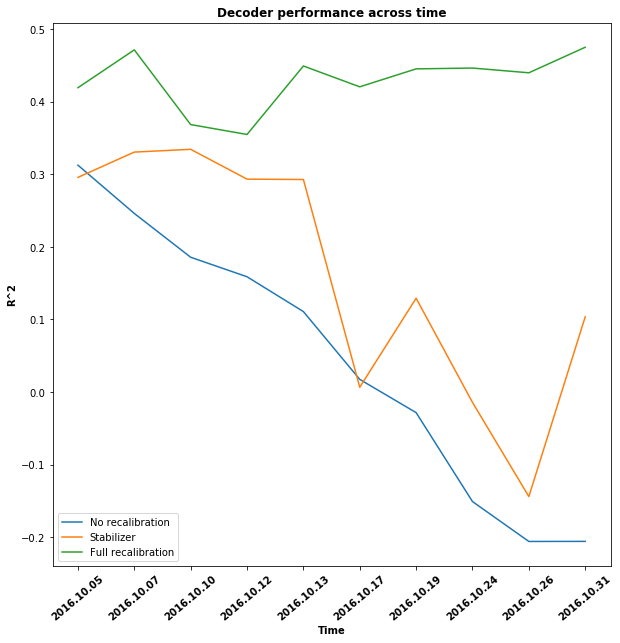

In [333]:
figSize(10, 10)

labels = ['No recalibration', 'Stabilizer', 'Full recalibration']
for i in range(3):
    plt.plot(scores[i, :].T, label = labels[i])
    
plt.xlabel('Time', fontweight = 'bold')
plt.ylabel('R^2', fontweight = 'bold')
plt.xticks(np.arange(len(date)), date, rotation = 40, fontweight = 'bold')
plt.title('Decoder performance across time', fontweight = 'bold')
plt.legend()

In [81]:
plt.plot()

array([2.60016985, 8.59484223])

In [ ]:
model_type         = 'PCA'
n_components       = 3
data               = np.dstack([dat.TX[i][:20, :] for i in np.where(dat.trialType == 'cursor')[0] ])
unique, conditions = np.unique(np.vstack([dat.targetPos[i][0, :] for i in np.where(dat.trialType == 'cursor')[0] ]), return_inverse = True, axis = 0)

model, ll     = fit_ConditionAveragedModel(model_type, {'n_components' : n_components}, data, conditions)